In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, mean_poisson_deviance

In [3]:
from scipy.stats import poisson

In [4]:
demand_df = pd.read_csv('demand_data.csv')
fare_df = pd.read_csv('predicted_fare.csv')

In [5]:
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fare         1004 non-null   float64
 1   bookings     1003 non-null   float64
 2   seasonindex  1004 non-null   object 
dtypes: float64(2), object(1)
memory usage: 23.7+ KB


In [6]:
demand_df[demand_df.bookings.isna()]

,fare,bookings,seasonindex
207,120.0,NaN,Off-Peak


In [7]:
# remove one row with missing booking information

demand_df.dropna(inplace=True)

In [8]:
demand_df.describe()

,fare,bookings
count,1003.000000,1003.000000
mean,155.091326,1.953141
std,30.877196,5.470552
min,100.080000,0.000000
25%,129.800000,0.000000
50%,154.650000,1.000000
75%,178.995000,3.000000
max,220.000000,110.000000


Max value of bookings is very high compared to mean. Investigate outliers. 

In [9]:
demand_df.sort_values(by='bookings', ascending=False)

,fare,bookings,seasonindex
890,220.00,110.0,Peak
349,140.00,99.0,Off-Peak
945,200.00,80.0,Peak
933,178.18,9.0,Peak
687,158.86,9.0,Peak
...,...,...,...
370,118.84,0.0,Off-Peak
377,198.78,0.0,Peak
737,133.47,0.0,Off-Peak
379,202.57,0.0,Peak


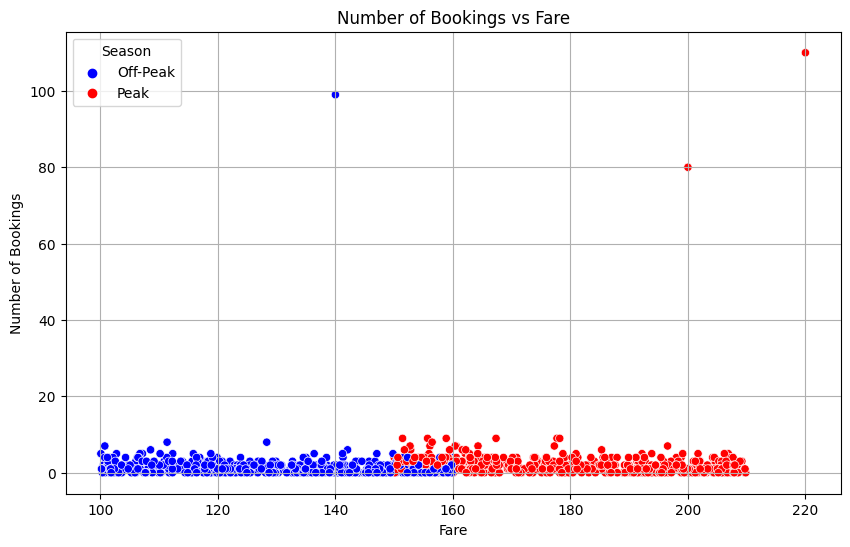

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=demand_df, x='fare', y='bookings', hue='seasonindex', palette=['blue', 'red'])
plt.title('Number of Bookings vs Fare')
plt.xlabel('Fare')
plt.ylabel('Number of Bookings')
plt.legend(title='Season')
plt.grid(True)
plt.savefig('outliers.png')


Filter out 3 outlier points

In [11]:
demand_df=demand_df.loc[demand_df.bookings<20,:]

Create separate plots for each season

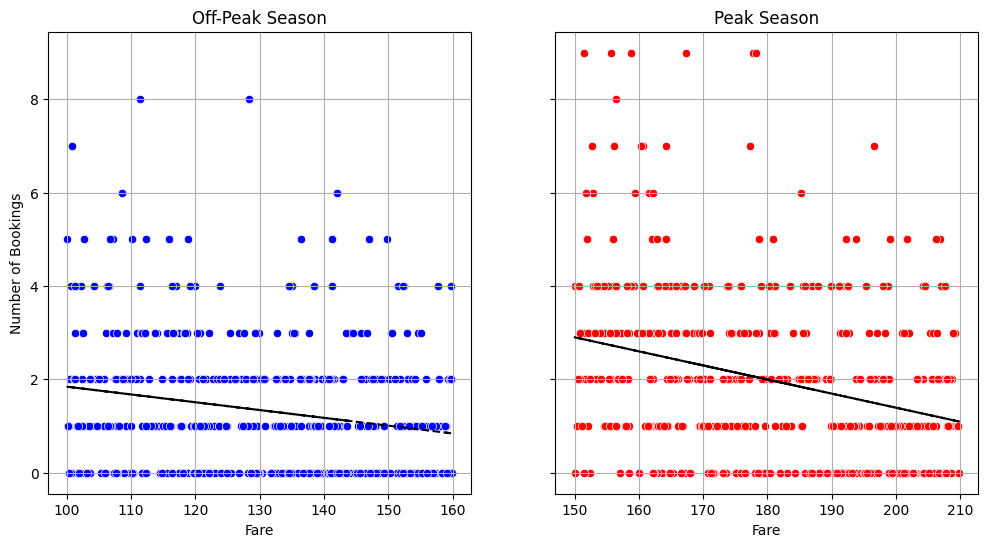

In [12]:

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Scatter plot for 'Off-Peak' season
sns.scatterplot(data=demand_df[demand_df['seasonindex'] == 'Off-Peak'], x='fare', y='bookings', ax=axes[0], color='blue')
axes[0].set_title('Off-Peak Season')
axes[0].set_xlabel('Fare')
axes[0].set_ylabel('Number of Bookings')
axes[0].grid(True)

# add regression line
season_df = demand_df[demand_df['seasonindex'] == 'Off-Peak']
X = season_df[['fare']]
y = season_df['bookings']
model = LinearRegression()
model.fit(X, y)
axes[0].plot(X, model.predict(X), linestyle='--', color='black')


# Scatter plot for 'Peak' season
sns.scatterplot(data=demand_df[demand_df['seasonindex'] == 'Peak'], x='fare', y='bookings', ax=axes[1], color='red')
axes[1].set_title('Peak Season')
axes[1].set_xlabel('Fare')
axes[1].set_ylabel('Number of Bookings')
axes[1].grid(True)

# add regression line
season_df = demand_df[demand_df['seasonindex'] == 'Peak']
X = season_df[['fare']]
y = season_df['bookings']
model = LinearRegression()
model.fit(X, y)
axes[1].plot(X, model.predict(X), linestyle='--', color='black')

plt.savefig('on-off-scatter.png')

## Observations

For both seasons:

- number of bookings show a decreasing trend as fare increases
- number of bookings are more concentrated around the average as fare goes up
- both the mean and variance of number of bookings are smaller decreases as fares go up

In [13]:
# create fare bins to see the trends clearly

bin_size = 5
fare_bins = range(100, 211, bin_size)

demand_df['fare_bin'] = pd.cut(demand_df['fare'], bins=fare_bins, right=False)
demand_df['bin_midpoint'] = demand_df['fare_bin'].map(lambda x:(x.left+x.right)/2)

In [14]:
demand_stats = demand_df.groupby(['seasonindex', 'fare_bin']) \
                        .agg(Mean_bookings=('bookings', 'mean'), 
                             Var_bookings=('bookings', 'var'), 
                             Midpoint=('bin_midpoint', 'max'), 
                             Mean_Fare=('fare', 'mean')) \
                        .reset_index()

demand_stats.dropna(inplace=True)

/var/folders/z8/5jzr021j7mvcglc_ctbzkb380000gp/T/ipykernel_86013/3503695125.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  demand_stats = demand_df.groupby(['seasonindex', 'fare_bin']) \


In [15]:
demand_stats['log_Mean_bookings'] = np.log(demand_stats['Mean_bookings'])

Check if the bins are poisson distributed

/usr/local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

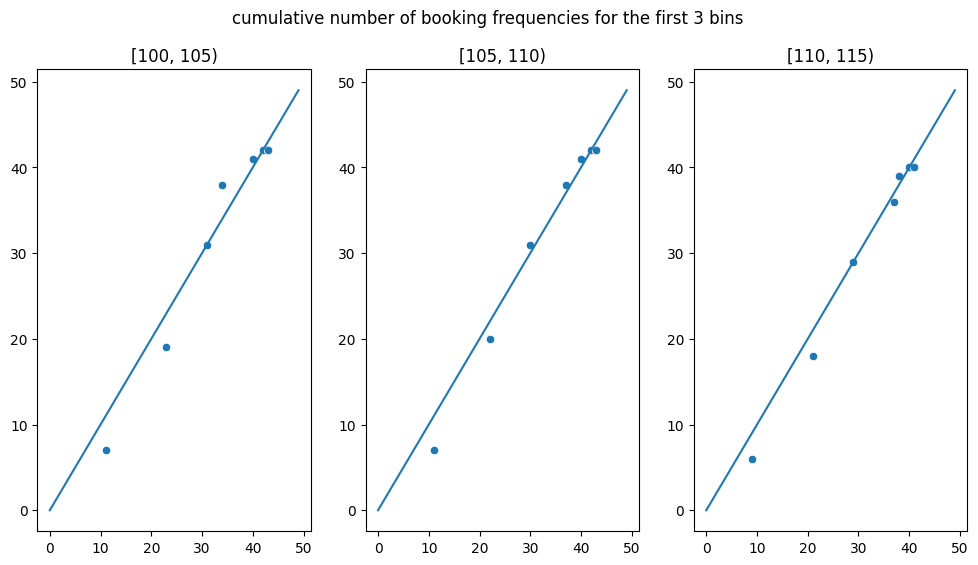

In [16]:

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
plt.suptitle('cumulative number of booking frequencies for the first 3 bins')

for i,bin in enumerate(demand_df.fare_bin.sort_values().unique()[0:3]):
    ax[i].set_title(bin)
    bookings = demand_df.loc[demand_df.fare_bin==bin, 'bookings']

    # Compute observed and cumulative frequencies
    observed, _ = np.histogram(bookings, bins=range(0,11))
    observed_cum = [sum(observed[:i]) for i in range(1,len(observed)+1)]

    # Compute expected cumulative frequencies assuming Poisson distribution with mean number of bookings in bin
    values = range(0, 10)  
    frequencies = poisson.cdf(values, bookings.mean())  

    
    sns.scatterplot(x=observed_cum, y=[int(i) for i in frequencies*len(bookings)], ax=ax[i])
    sns.lineplot(x=range(0,50), y=range(0,50), ax=ax[i])
    plt.savefig('cumulative-poisson.png')


/usr/local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


/usr/local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(43.503604600694445, 0.5, 'Average number of bookings in bin')

<Figure size 1200x600 with 0 Axes>

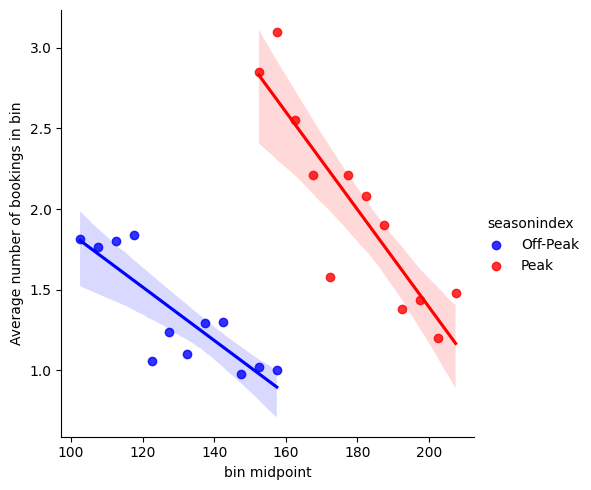

In [17]:
plt.figure(figsize=(12,6))
sns.lmplot(data=demand_stats, x='Midpoint', y='Mean_bookings', hue='seasonindex', palette=['blue', 'red'])

plt.xlabel('bin midpoint')
plt.ylabel('Average number of bookings in bin')



/usr/local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x600 with 0 Axes>

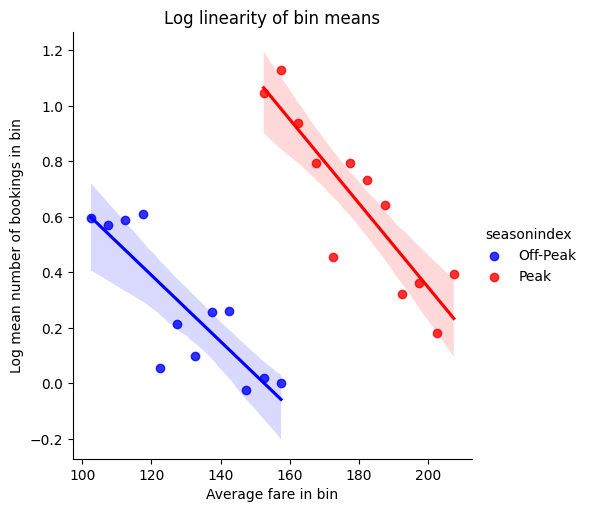

In [18]:
plt.figure(figsize=(12,6))
sns.lmplot(data=demand_stats, x='Midpoint', y='log_Mean_bookings', hue='seasonindex', palette=['blue', 'red'])

plt.xlabel('Average fare in bin')
plt.ylabel('Log mean number of bookings in bin')
plt.title('Log linearity of bin means')
plt.savefig('log-linear-means')

In [19]:
demand_df_off_peak = demand_df.loc[demand_df.seasonindex=='Off-Peak',:]

/usr/local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

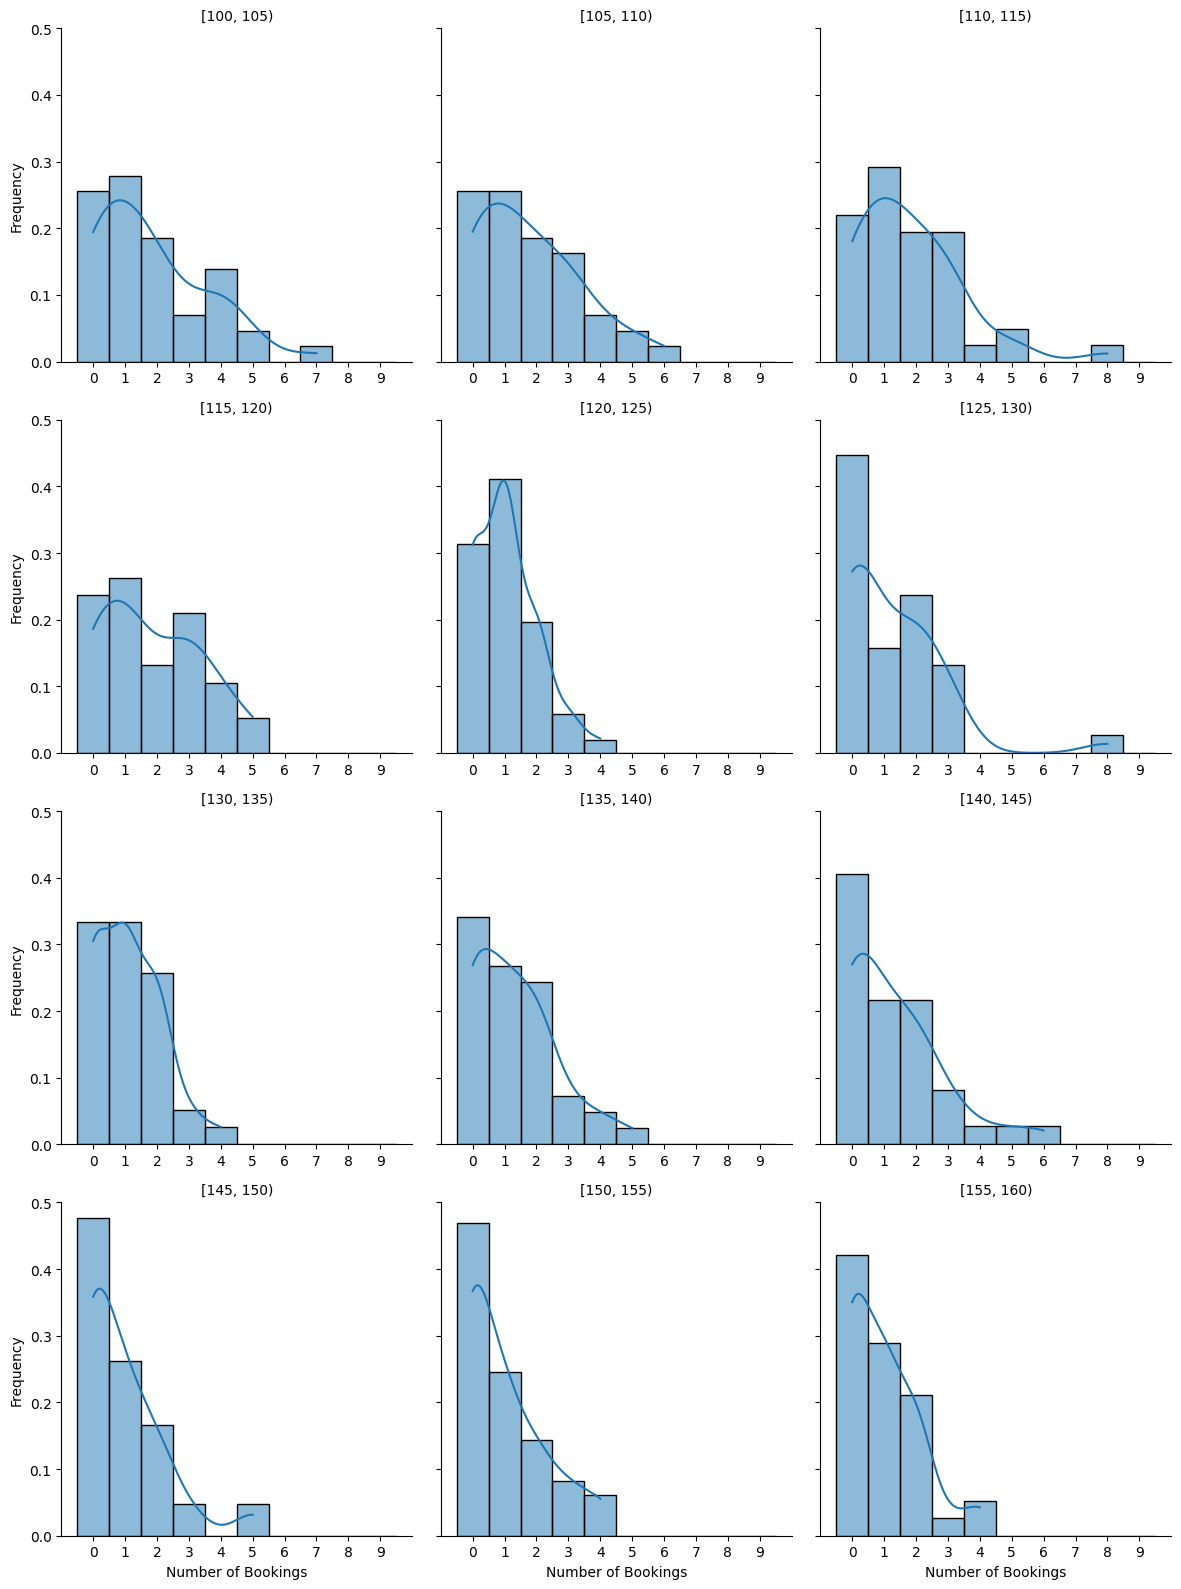

In [20]:

off_peak_fare_bins = demand_df_off_peak['fare_bin'].unique().sort_values()

# Create the FacetGrid
g = sns.FacetGrid(demand_df_off_peak, col='fare_bin', col_wrap=3, height=4, sharex=False, col_order=off_peak_fare_bins)

# Map the histograms to the FacetGrid
g.map_dataframe(sns.histplot, x='bookings', bins=np.arange(-.5,10,1), kde=True, stat='probability')


g.set_titles('{col_name}')
g.set_axis_labels('Number of Bookings', 'Frequency')

for ax in g.axes.flat:
    ax.set_xticks(range(0, 10))
plt.savefig('bin-distributions')


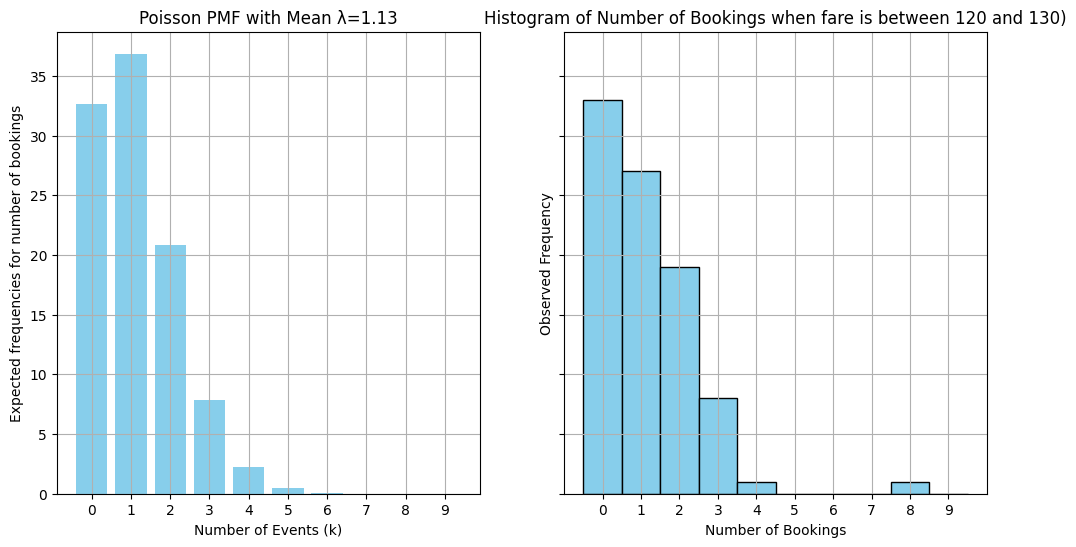

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True)

# Filter data for bookings greater than 20 and fare range 120-130
filtered_demand_df = demand_df[(demand_df['fare'] >= 120) & (demand_df['fare'] <= 130)]

ax[1].hist(filtered_demand_df['bookings'], bins=np.arange(-.5,10,1), color='skyblue', edgecolor='black')
ax[1].set_title('Histogram of Number of Bookings when fare is between 120 and 130)')
ax[1].set_xlabel('Number of Bookings')
ax[1].set_ylabel('Observed Frequency')
ax[1].set_xticks(np.arange(0,10))
ax[1].grid(True)


mean_lambda = filtered_demand_df.bookings.mean().round(2)
  
pmf_values = poisson.pmf(np.arange(0,10), mu=mean_lambda)

# Plot the PMF

ax[0].bar(np.arange(0,10), pmf_values*(filtered_demand_df.bookings.sum()), color='skyblue')
ax[0].set_title(f'Poisson PMF with Mean λ={mean_lambda}')
ax[0].set_xlabel('Number of Events (k)')
ax[0].set_ylabel('Expected frequencies for number of bookings')
ax[0].set_xticks(np.arange(0,10))
ax[0].grid(True)

plt.savefig('poisson_vs_bin')



## Model Selection

In [22]:
X = demand_df[['fare', 'seasonindex']]
y = demand_df['bookings'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=.2, random_state=12)

Find optimal power function

In [23]:
# transformations for power function

class PowerTr(BaseEstimator, TransformerMixin):
    def __init__(self, exponent=3):
        self.exponent = exponent

    def fit(self, X, y=None):
        return self

    def transform(self, X):
         X_copy = X.copy()
         X_copy['fare'] = np.power(X['fare'], self.exponent)
         return X_copy

one_hot_encoder = ColumnTransformer(
    transformers=[
        ('one_hot_encoder', OneHotEncoder(sparse_output=False, drop='first'), ['seasonindex'])
    ],
    remainder='passthrough',
    verbose_feature_names_out = False
).set_output(transform='pandas')


In [24]:
mse = []

for exponent in np.arange(5, -2, -.1):
    power_transformer = PowerTr(exponent)
    X_train_oh  = one_hot_encoder.fit_transform(X_train)
    X_train_power = power_transformer.transform(X_train_oh)

    lm_model = LinearRegression()
    scores_mse = cross_val_score(lm_model, X_train_power, y_train, cv=10, scoring='neg_mean_squared_error')
    mse.append(-scores_mse.mean())
    
    

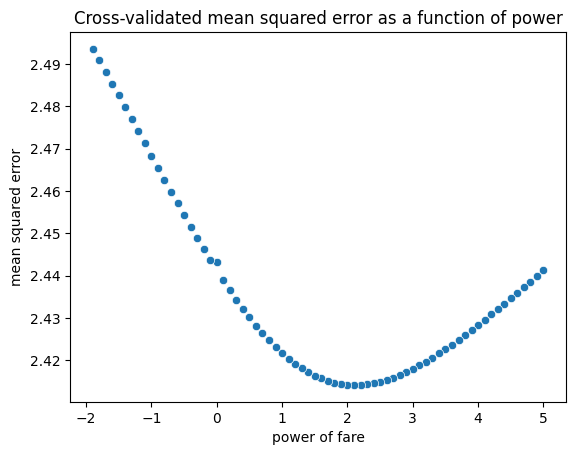

In [25]:
sns.scatterplot(x=np.arange(5, -2, -.1), y=mse)
plt.title('Cross-validated mean squared error as a function of power')
plt.ylabel('mean squared error')
plt.xlabel('power of fare')
plt.savefig('power_cv_errors')

Evaluate other models with cross validation

In [26]:
one_hot_encoder = ColumnTransformer(
    transformers=[
        ('oh', OneHotEncoder(drop='first'), ['seasonindex'])
    ],
    remainder='passthrough'
)


models = [
    ('Linear Regression', LinearRegression()),
    ('Poisson Regression', PoissonRegressor(alpha=0)),
    ('Quadratic Linear Regression', Pipeline([
        ('poly', PolynomialFeatures(2)),
        ('linear', LinearRegression())
    ]))
]

all_predictions = []
scores = pd.DataFrame(columns=['Linear Regression', 'Poisson Regression', 'Quadratic Linear Regression'])


for name, model in models:
    pipeline = Pipeline(steps=[('one_hot_encoder', one_hot_encoder), ('model', model)])
    
    poisson_dev = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='neg_mean_poisson_deviance')
    print(f"{name}: Mean Unit Deviance: {-poisson_dev.mean()}, Std Unit Deviance: {poisson_dev.std()}")
    
    mse = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    print(f"{name}: Mean Squared Error: {-mse.mean()}, Std Unit Deviance: {mse.std()}")
    
    scores[name] = [-mse.mean(), -poisson_dev.mean()]

    predictions = cross_val_predict(pipeline, X_train, y_train, cv=10)
    all_predictions.append(predictions)

    

Linear Regression: Mean Unit Deviance: 1.5529753204355023, Std Unit Deviance: 0.16595149209328278
Linear Regression: Mean Squared Error: 2.4216679841587982, Std Unit Deviance: 0.5339148537943786
Poisson Regression: Mean Unit Deviance: 1.5344272765674005, Std Unit Deviance: 0.15211934061598964
Poisson Regression: Mean Squared Error: 2.3991676046056485, Std Unit Deviance: 0.5212309379116352
Quadratic Linear Regression: Mean Unit Deviance: 1.5353832023535867, Std Unit Deviance: 0.14806607974662508
Quadratic Linear Regression: Mean Squared Error: 2.402032227603321, Std Unit Deviance: 0.5150356462089274


In [27]:
scores = scores.set_axis(['mean squared error', 'poisson deviance'], axis=0)

In [28]:
X_test_peak = X_test.loc[X_test.seasonindex=='Peak',:]
peak_idx = X_test_peak.index
y_test_peak = y_test[peak_idx]

In [29]:
predictions = []
peak_predictions = []
mse_test_errors = []
for name, model in models:
    pipeline = Pipeline(steps=[('one_hot_encoder', one_hot_encoder), ('model', model)])
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    y_pred_peak = pipeline.predict(X_test_peak)
    
    predictions.append(y_pred)
    peak_predictions.append(y_pred_peak)

    mse_test_errors.append(((y_pred-y_test)**2).mean())
    

In [30]:
scores.loc['test mse'] = pd.Series(mse_test_errors, index=scores.columns)


In [31]:
scores = scores.reset_index().rename({'index':'Error'}, axis=1)

In [32]:
scores

,Error,Linear Regression,Poisson Regression,Quadratic Linear Regression
0,mean squared error,2.421668,2.399168,2.402032
1,poisson deviance,1.552975,1.534427,1.535383
2,test mse,2.559342,2.547589,2.554741


In [33]:
# Save table as figure

plt.figure(figsize=(10, 6))
plt.table(cellText=scores.values, colLabels=scores.columns, loc='center')
plt.axis('off')  
plt.savefig('model_scores.png', bbox_inches='tight')  
plt.close()

(array([55., 51., 39., 24., 20.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <BarContainer object of 5 artists>)

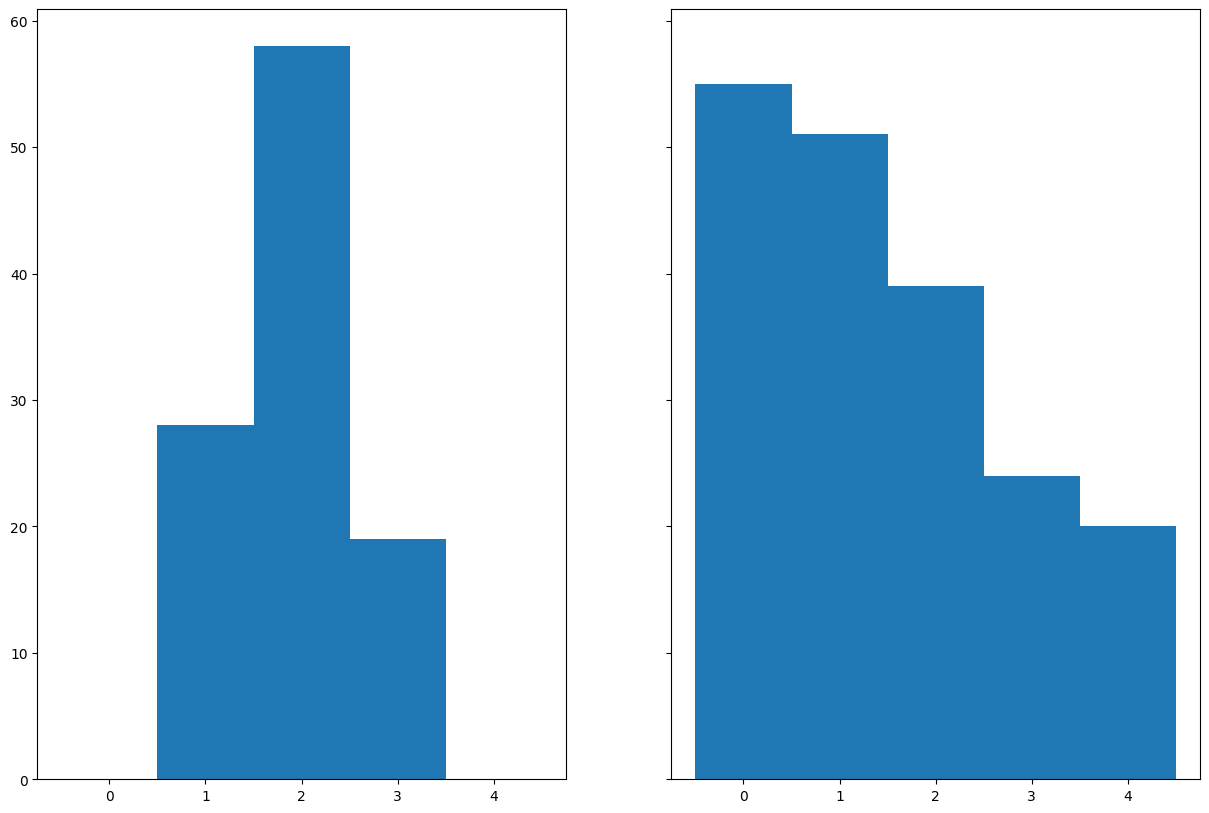

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), sharey=True)
axes[0].hist(peak_predictions[1], bins=[x-.5 for x in range(0,6)])
axes[1].hist(y_test, bins=[x-.5 for x in range(0,6)])


## Train the Poisson model on the whole data

In [35]:
poisson_model = PoissonRegressor(alpha=0)
X_oh  = one_hot_encoder.fit_transform(X)

poisson_model.fit(X_oh, y)

PoissonRegressor(alpha=0)

In [36]:
poisson_model.intercept_

2.1211476190951424

In [37]:
coefs = poisson_model.coef_
coefs, fare_df.iloc[0]

(array([ 1.1095396, -0.0142907]),
 Fares ($)    220
 Name: 0, dtype: int64)

In [38]:
np.exp(coefs)

array([3.0329617 , 0.98581093])

## Make predictions for higher prices

In [39]:
fare_df['seasonindex_Peak'] = 1

fare_df = fare_df.rename({'Fares ($)':'fare'}, axis=1)
fare_df = fare_df[['seasonindex_Peak', 'fare']]


In [40]:
peak_predictions_poisson = poisson_model.predict(fare_df)

/usr/local/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PoissonRegressor was fitted without feature names
  warnings.warn(


In [41]:
peak_predictions_poisson

array([1.09060622, 0.94537531, 0.81948413, 0.71035728, 0.61576234,
       0.53376416, 0.4626853 , 0.40107167, 0.34766284, 0.30136621,
       0.26123469, 0.2264473 , 0.19629237, 0.17015304, 0.14749456,
       0.1278534 , 0.11082777, 0.09606935, 0.08327625])

In [42]:
fare_df['seasonindex_Peak'] = 0
off_peak_predictions_poisson = poisson_model.predict(fare_df)

/usr/local/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PoissonRegressor was fitted without feature names
  warnings.warn(


In [43]:
off_peak_predictions_poisson

array([0.35958457, 0.31170038, 0.2701927 , 0.23421241, 0.20302345,
       0.17598777, 0.1525523 , 0.13223763, 0.11462817, 0.09936367,
       0.08613188, 0.0746621 , 0.0647197 , 0.05610128, 0.04863054,
       0.04215464, 0.0365411 , 0.0316751 , 0.02745707])

In [44]:
final_predictions_poisson = pd.DataFrame({'fare':fare_df.fare,
                                           'peak_bookings':peak_predictions_poisson, 
                                           'off_peak_bookings':off_peak_predictions_poisson}) 

In [45]:
final_predictions_poisson

,fare,peak_bookings,off_peak_bookings
0,220,1.090606,0.359585
1,230,0.945375,0.311700
2,240,0.819484,0.270193
3,250,0.710357,0.234212
4,260,0.615762,0.203023
5,270,0.533764,0.175988
6,280,0.462685,0.152552
7,290,0.401072,0.132238
8,300,0.347663,0.114628
9,310,0.301366,0.099364


In [46]:
# save table as png

plt.figure(figsize=(10, 6))
plt.table(cellText=final_predictions_poisson.values, colLabels=final_predictions_poisson.columns, loc='center')
plt.axis('off')  
plt.savefig('final_predictions_poisson.png', bbox_inches='tight')  
plt.close()

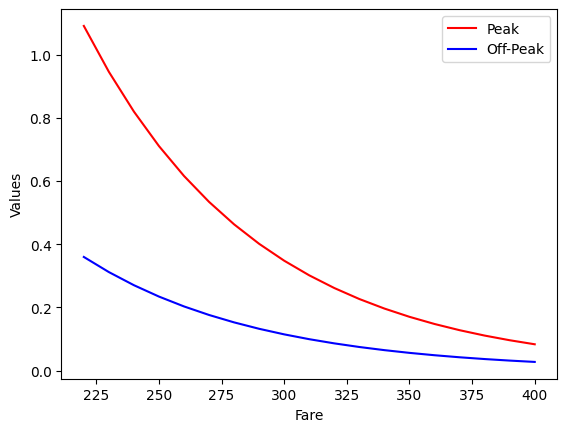

In [47]:
plt.plot(fare_df.fare, final_predictions_poisson.peak_bookings, color='red', label='Peak')

plt.plot(fare_df.fare, final_predictions_poisson.off_peak_bookings, color='blue', label='Off-Peak')

# Add labels and legend
plt.xlabel('Fare')
plt.ylabel('Values')
plt.legend()
plt.savefig('predictions_poisson')
